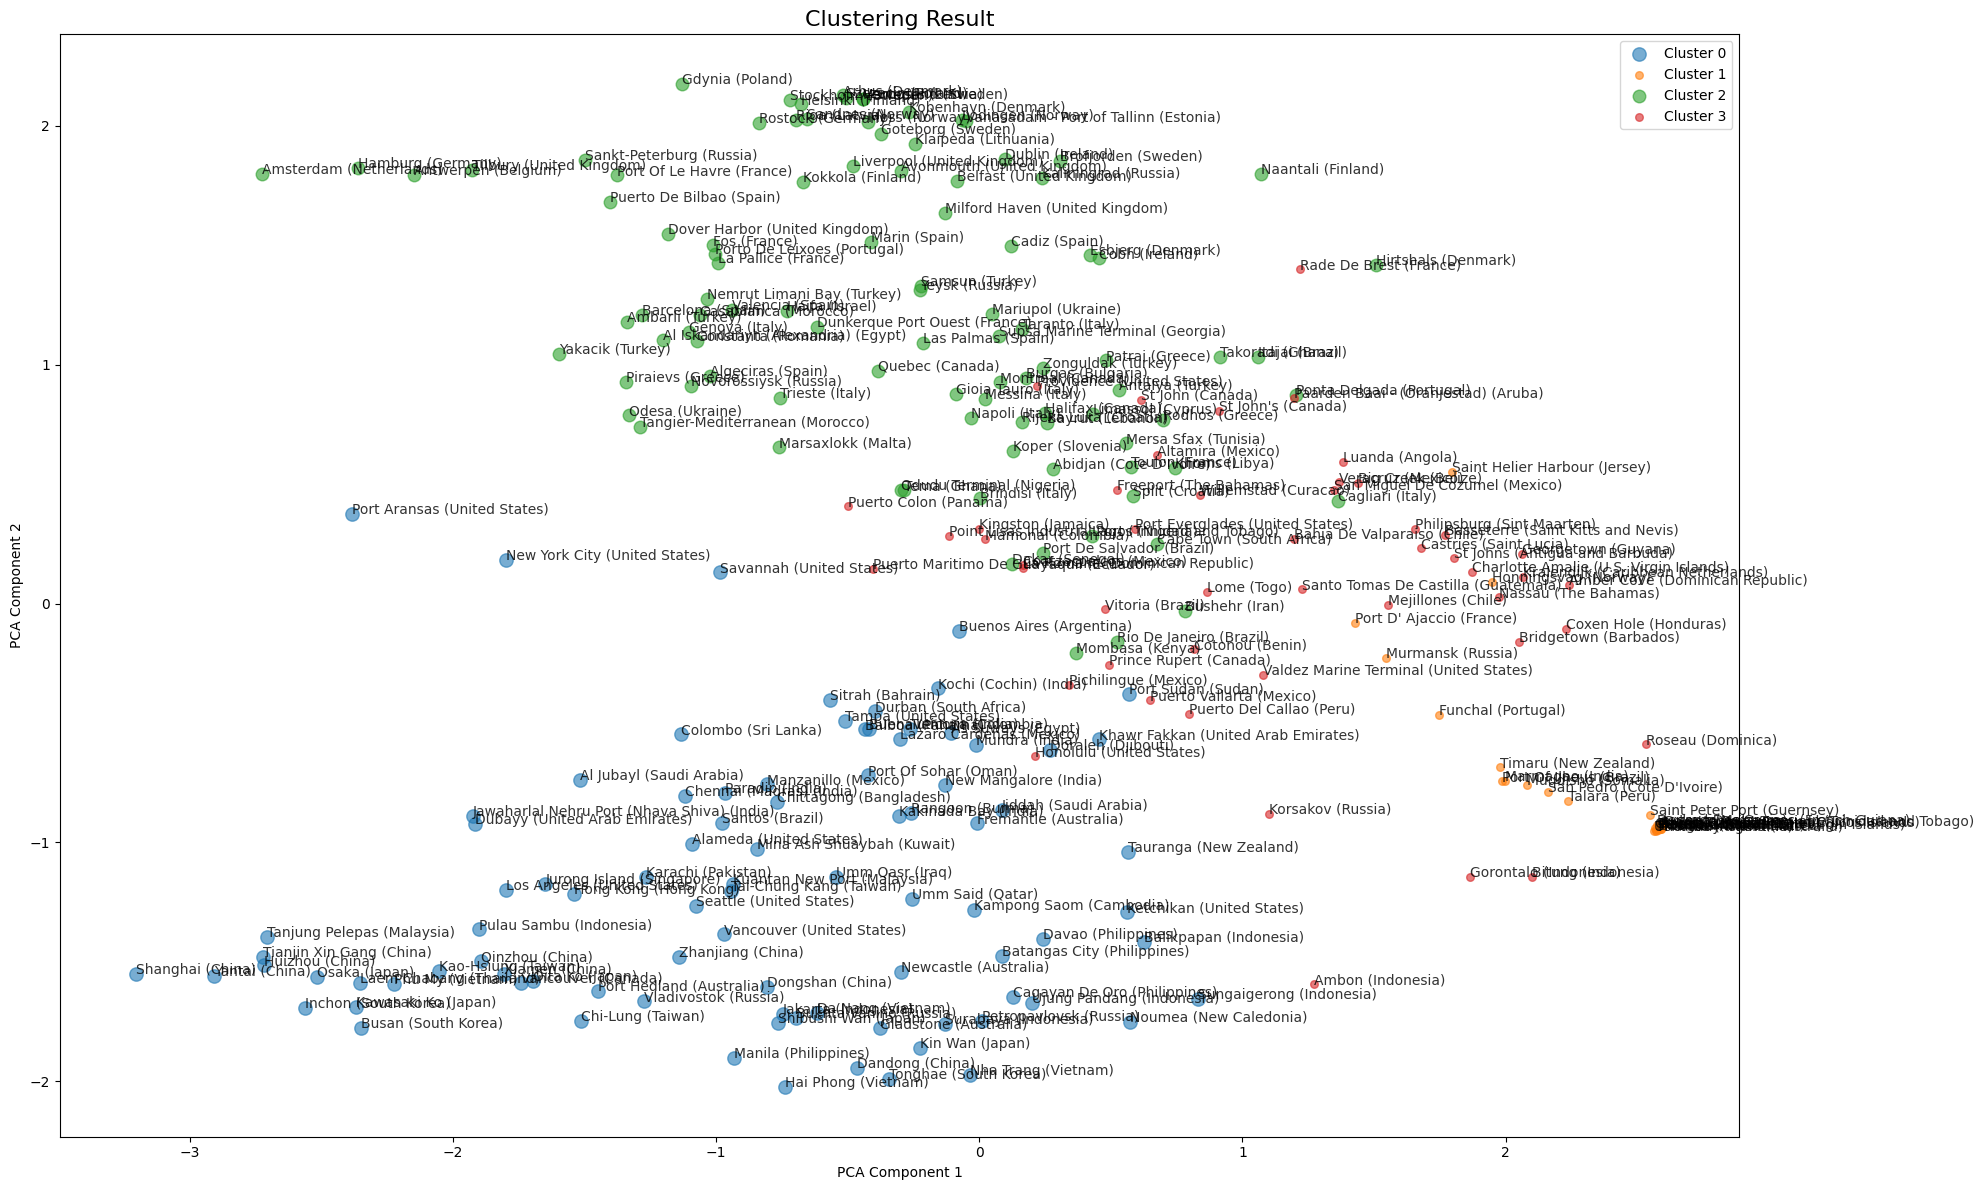

In [217]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import geopandas as gpd
from shapely.geometry import Point
from sklearn.preprocessing import StandardScaler

name = 'ru'

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
n_clusters = 4

# 1. 加载节点的地理信息
clusters = pd.read_feather(f'result/clusters/cl_{name}.feather')

# 2. 加载节点嵌入数据
node_embeddings = pd.read_csv(f'result/graph_embedding/{name}/nodeembs_before_lstmB_structure.csv', header=None)
node_embeddings = node_embeddings.values[:, 1:]  # 将数据转换为NumPy数组，并去除第一列（第一列是标签，不参与拟合）

# 如果 clusters 的行数多于嵌入数量，则裁剪 clusters
if clusters.shape[0] > node_embeddings.shape[0]:
    clusters = clusters.iloc[:node_embeddings.shape[0]].reset_index(drop=True)

# 3. 使用KMeans对节点嵌入进行聚类
kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_SEED)
clusters['cluster'] = kmeans.fit_predict(node_embeddings)

# 4. 进行PCA降维，以便进行可视化
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(node_embeddings)

# 5. 将PCA降维结果添加到clusters数据框中
clusters['pca_x'] = reduced_embeddings[:, 0]
clusters['pca_y'] = reduced_embeddings[:, 1]

# 只保留大港口
# clusters = clusters[clusters['ship_cnts'] > 1000]

# 提取港口标签
clusters['port_info'] = clusters.apply(
    lambda row: f"{row['nearest_ports'].split(',')[0]} ({row['country_water_body'].split('_')[0]})",
    axis=1
)

# 6. 绘制聚类结果
plt.figure(figsize=(20, 12))
cmap = plt.get_cmap('tab10')
colors = [cmap(i) for i in range(n_clusters)]

# 遍历每个聚类类别
for cl in sorted(clusters['cluster'].unique()):
    sub_df = clusters[clusters['cluster'] == cl]
    plt.scatter(sub_df['pca_x'], sub_df['pca_y'],
                s=2.0 * np.sqrt(np.mean(sub_df['ship_cnts'])),
                color=colors[cl % len(colors)], 
                label=f'Cluster {cl}', alpha=0.6)
    # 对每个点添加港口标签
    for idx, row in sub_df.iterrows():
        plt.annotate(row['port_info'], (row['pca_x'], row['pca_y']), fontsize=10, alpha=0.8)

plt.title('Clustering Result', fontsize=16)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.tight_layout()
plt.show()


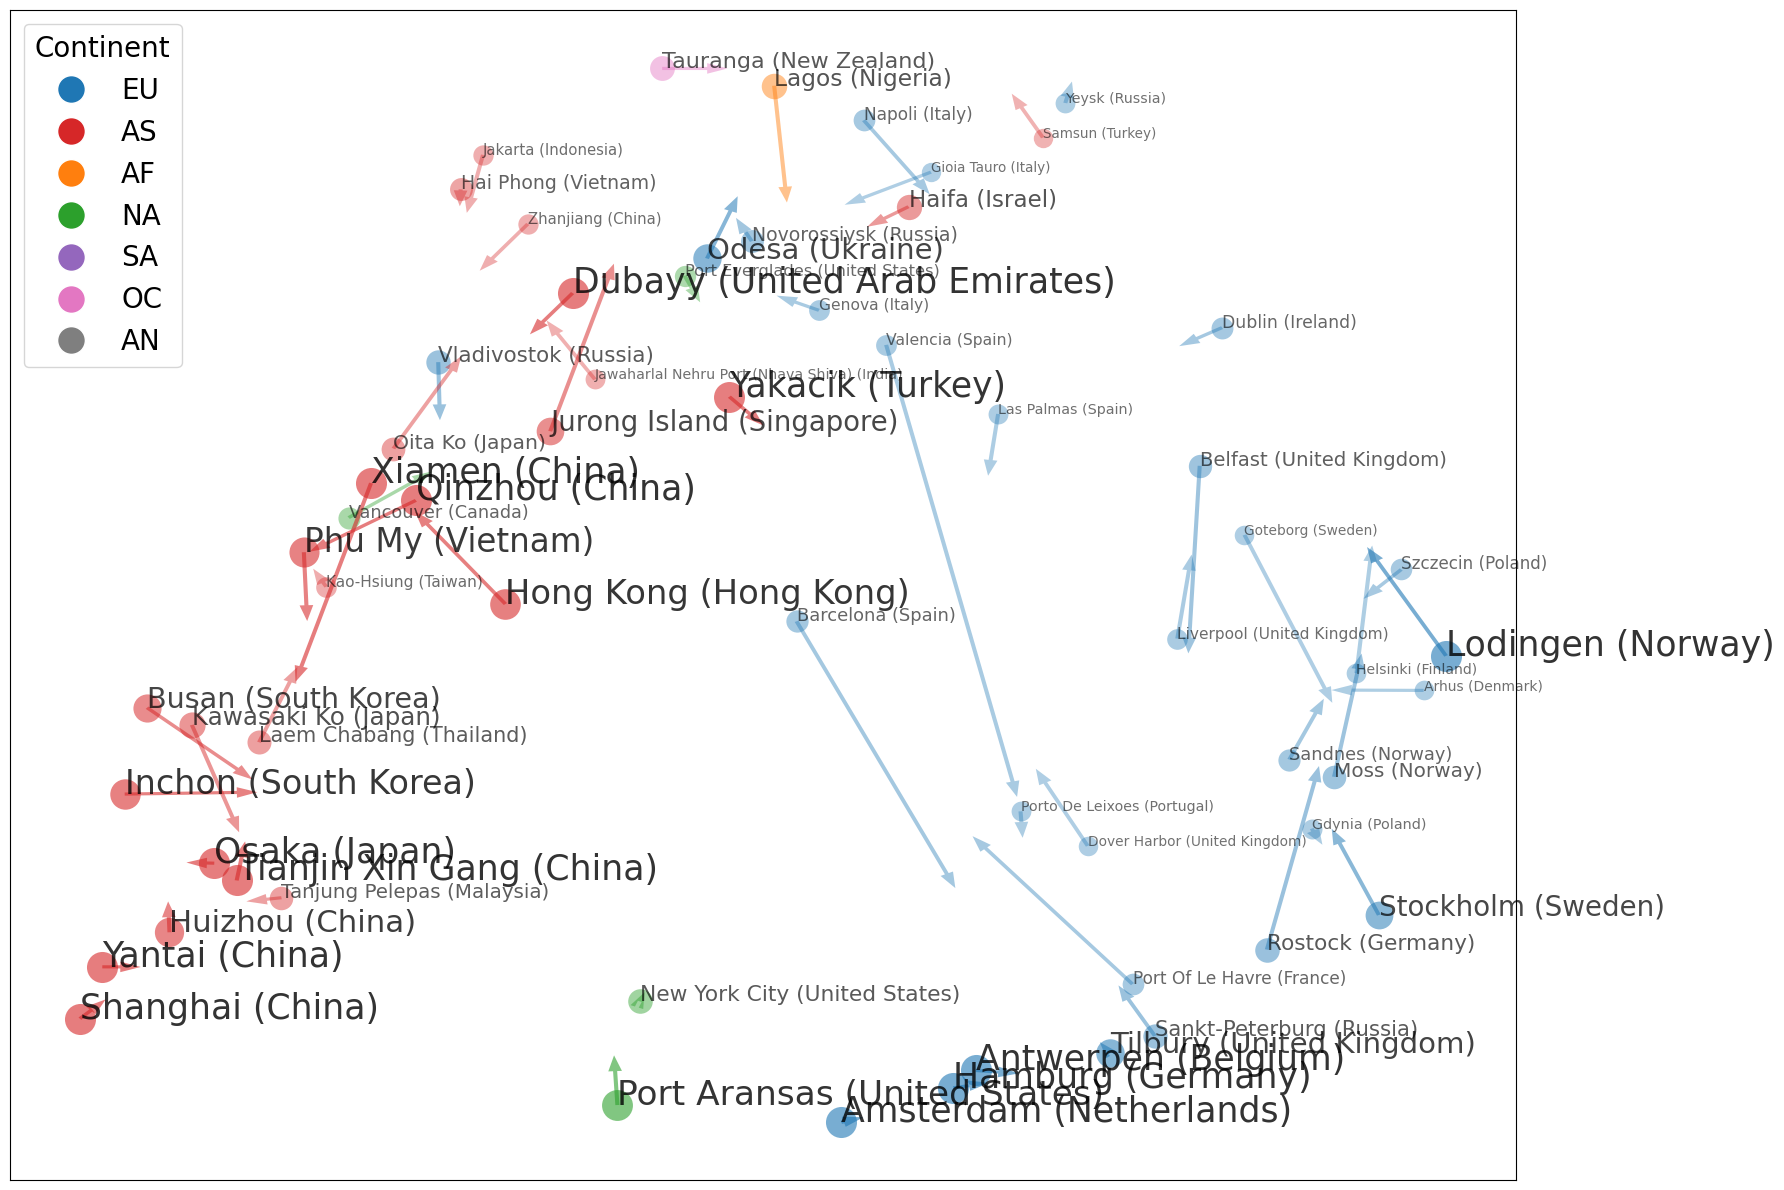

In [218]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from sklearn.decomposition import PCA
from sklearn.preprocessing import QuantileTransformer
import reverse_geocoder as rg
import pycountry_convert as pc

name = 'ru'

# 固定随机种子
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# 1. 加载节点聚类和嵌入数据
clusters = gpd.read_feather(f'result/clusters/cl_{name}.feather')
node_embeddings_before = pd.read_csv(f'result/graph_embedding/{name}/nodeembs_before_lstmB_structure.csv', header=None)
node_embeddings_after = pd.read_csv(f'result/graph_embedding/{name}/nodeembs_after_lstmB_structure.csv', header=None)

# 去除第一列节点 ID，只保留向量
embeddings_before = node_embeddings_before.iloc[:, 1:].values
embeddings_after = node_embeddings_after.iloc[:, 1:].values

# 保证行数一致
n_nodes = min(len(embeddings_before), len(embeddings_after), len(clusters))
embeddings_before = embeddings_before[:n_nodes]
embeddings_after = embeddings_after[:n_nodes]
clusters = clusters.iloc[:n_nodes].reset_index(drop=True)

# 只保留大港口
main_ports = clusters['ship_cnts'] > 1500
embeddings_before = embeddings_before[main_ports.values]
embeddings_after = embeddings_after[main_ports.values]
clusters = clusters[main_ports].reset_index(drop=True)

# 提取港口标签
clusters['port_info'] = clusters.apply(
    lambda row: f"{row['nearest_ports'].split(',')[0]} ({row['country_water_body'].split('_')[0]})",
    axis=1
)

# PCA 降维后的二维坐标
pca = PCA(n_components=2)
pca_before = pca.fit_transform(embeddings_before)
pca_after = pca.transform(embeddings_after)

# clusters['pca_x_before'] = pca_before[:, 0]
# clusters['pca_y_before'] = pca_before[:, 1]
# clusters['pca_x_after'] = pca_after[:, 0]
# clusters['pca_y_after'] = pca_after[:, 1]
# 2. QuantileTransformer 边缘均匀化到 [0,1]
qt = QuantileTransformer(
    n_quantiles=pca_before.shape[0],
    output_distribution='uniform',
    random_state=RANDOM_SEED
)
qt_before = qt.fit_transform(pca_before)
qt_after  = qt.transform(pca_after)

# （可选）如果想把 [0,1] 映射到 [-1,1]：
# qt_before = qt_before * 2 - 1
# qt_after  = qt_after  * 2 - 1

# 3. 覆盖原来的列
clusters['pca_x_before'] = qt_before[:, 0]
clusters['pca_y_before'] = qt_before[:, 1]
clusters['pca_x_after']  = qt_after[:,  0]
clusters['pca_y_after']  = qt_after[:,  1]

# 为每个节点分配颜色
# colors = plt.cm.tab20(np.linspace(0, 1, len(clusters)))

clusters['centroid'] = clusters.to_crs(epsg=3857).geometry.centroid.to_crs(epsg=4326)   # 获取几何质心
clusters['centroid_lon'] = clusters['centroid'].x
clusters['centroid_lat'] = clusters['centroid'].y

# norm_x = Normalize(vmin=clusters['centroid_lon'].min(), vmax=clusters['centroid_lon'].max())
# norm_y = Normalize(vmin=clusters['centroid_lat'].min(), vmax=clusters['centroid_lat'].max())
# colors = np.array([[norm_x(x), norm_y(y), (norm_x(x) + norm_y(y)) / 2] for x, y in zip(clusters['centroid_lon'], clusters['centroid_lat'])])

# 通过 reverse geocoder 获取对应国家 [{'cc': 'US', 'name': ..., ...}, ...]
results = rg.search(list(zip(clusters['centroid_lat'], clusters['centroid_lon'])))

# 获取大洲（continent code）
def country_to_continent(country_code):
    try:
        return pc.country_alpha2_to_continent_code(country_code)
    except:
        return 'Other'

continent_codes = [country_to_continent(res['cc']) for res in results]

# 为每个大洲分配固定颜色
continent_color_map = {
    'EU': 'tab:blue',
    'AS': 'tab:red',
    'AF': 'tab:orange',
    'NA': 'tab:green',
    'SA': 'tab:purple',
    'OC': 'tab:pink',
    'AN': 'tab:gray',
    # 'Other': 'black'
}

clusters['continent'] = continent_codes
colors = clusters['continent'].map(continent_color_map)

max_ship_cnts = clusters['ship_cnts'].max()

# 绘图
plt.figure(figsize=(18, 12))
for i, row in clusters.iterrows():
    color = colors[i]

    norm = np.sqrt(row['ship_cnts']) / np.sqrt(max_ship_cnts)

    # 绘制箭头：从 before 指向 after
    plt.arrow(row['pca_x_before'], row['pca_y_before'],
              row['pca_x_after'] - row['pca_x_before'],
              row['pca_y_after'] - row['pca_y_before'],
              color=color, alpha=0.2 + 0.4 * norm, linewidth=0, width=0.003, head_width=0.01, length_includes_head=True)

    # 绘制起始点，大小与 ship_cnts 成比例
    plt.scatter(row['pca_x_before'], row['pca_y_before'],
                color=color, s=500.0 * norm, alpha=0.2 + 0.4 * norm, linewidth=0)

    # 添加港口标签
    plt.annotate(row['port_info'], (row['pca_x_before'], row['pca_y_before']),
                 fontsize=25.0 * norm, alpha=0.4 + 0.4 * norm)

# 图形设置
plt.xticks([])
plt.yticks([])
plt.legend(handles=[
    Patch(facecolor=color, edgecolor='k', label=continent)
    for continent, color in continent_color_map.items()
], title="Continent", loc='lower right')
plt.legend(handles=[
    Line2D([0], [0], marker='o', color='w', label=continent,
           markerfacecolor=color, markersize=20)
    for continent, color in continent_color_map.items()
], title="Continent", title_fontsize=20, fontsize=20, loc='best')
plt.tight_layout()
plt.show()


In [219]:
import numpy as np
import pandas as pd
import geopandas as gpd
import os

name = 'ru'
output_path = f'result/graph_embedding/{name}/'
os.makedirs(output_path, exist_ok=True)

# 固定随机种子
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# 加载数据
clusters = gpd.read_feather(f'result/clusters/cl_{name}.feather')
emb_before = pd.read_csv(f'{output_path}nodeembs_before_lstmB_structure.csv', header=None).iloc[:, 1:].values
emb_after  = pd.read_csv(f'{output_path}nodeembs_after_lstmB_structure.csv', header=None).iloc[:, 1:].values

# 对齐数量
n = min(len(clusters), len(emb_before), len(emb_after))
clusters = clusters.iloc[:n].reset_index(drop=True)
emb_before = emb_before[:n]
emb_after  = emb_after[:n]

# 提取港口标签
clusters['port_info'] = clusters.apply(
    lambda row: f"{row['nearest_ports'].split(',')[0]} ({row['country_water_body'].split('_')[0]})",
    axis=1
)

# 计算几何质心（经纬度）
clusters = clusters.to_crs(epsg=3857)
clusters['centroid'] = clusters.geometry.centroid
clusters = clusters.set_geometry('centroid').to_crs(epsg=4326)
clusters['centroid_lon'] = clusters.geometry.x
clusters['centroid_lat'] = clusters.geometry.y

# 计算余弦距离作为受影响度
dot_product = np.sum(emb_before * emb_after, axis=1)
norms = np.linalg.norm(emb_before, axis=1) * np.linalg.norm(emb_after, axis=1)
clusters['influence'] = 1.0 - dot_product / (norms + 1e-8)  # 防止除0

# 过滤小港口
# clusters = clusters[clusters['ship_cnts'] > 1500].reset_index(drop=True)

# 归一化（min-max）处理后的影响度
clusters['influence'] = (clusters['influence'] - clusters['influence'].min()) / (clusters['influence'].max() - clusters['influence'].min() + 1e-8)

# 构建输出 DataFrame
heatmap_df = clusters[['centroid_lat', 'centroid_lon', 'ship_cnts', 'port_info', 'influence']].copy()

# 保存为 CSV
heatmap_df.to_csv(f'{output_path}port_influence.csv', index=False)

print(f"成功输出港口受影响度热力表到 {output_path}port_influence.csv")


成功输出港口受影响度热力表到 result/graph_embedding/ru/port_influence.csv


before threshold = 12.113, after threshold = 11.236

=== 社区检测指标对比 ===
                        before      after
n_communities         8.000000   8.000000
mean_community_size  32.875000  32.875000
std_community_size   15.103290  13.013815
silhouette            0.264337   0.332997
calinski_harabasz    50.939475  67.826582
davies_bouldin        1.373169   1.273251


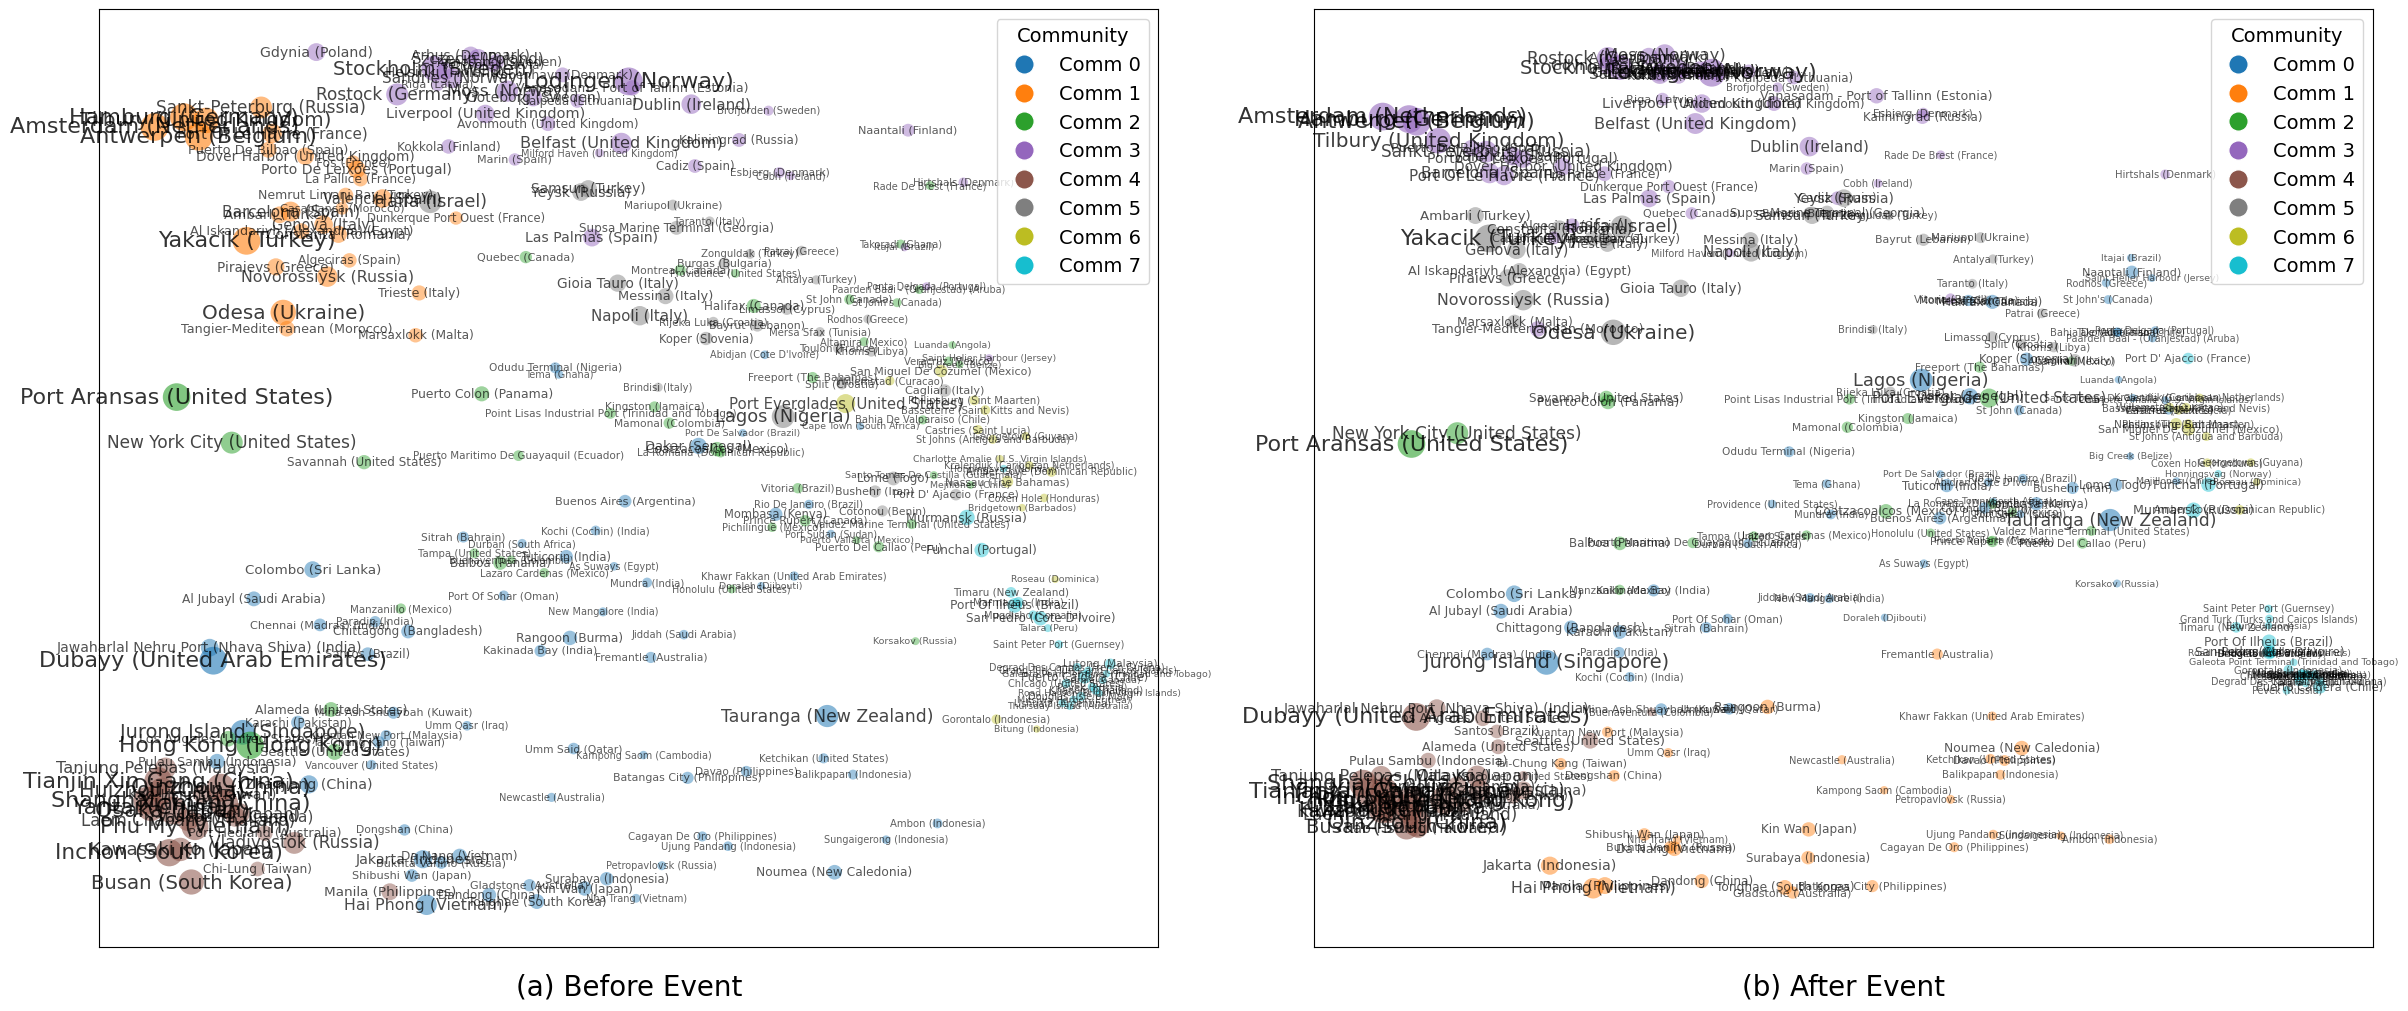

In [220]:
import numpy as np
import pandas as pd
import geopandas as gpd
import networkx as nx
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score
)
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import QuantileTransformer
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# -------------------
# 配置
# -------------------
name = 'ru'
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# -------------------
# 1. 加载地理节点数据和前后嵌入
# -------------------
cluster = gpd.read_feather(f'result/clusters/cl_{name}.feather')
emb_before = pd.read_csv(
    f'result/graph_embedding/{name}/nodeembs_before_lstmB_structure.csv',
    header=None
).iloc[:,1:].values
emb_after = pd.read_csv(
    f'result/graph_embedding/{name}/nodeembs_after_lstmB_structure.csv',
    header=None
).iloc[:,1:].values

# 对齐行数
n = min(len(cluster), emb_before.shape[0], emb_after.shape[0])
cluster = cluster.iloc[:n].reset_index(drop=True)
emb_before = emb_before[:n]
emb_after  = emb_after[:n]

# 提取港口标签
cluster['port_info'] = cluster.apply(
    lambda row: f"{row['nearest_ports'].split(',')[0]} ({row['country_water_body'].split('_')[0]})",
    axis=1
)

# -------------------
# 2. 层次聚类
# -------------------
from scipy.cluster.hierarchy import linkage
percentage = 97.5

Zb = linkage(emb_before, method='ward')
Za = linkage(emb_after,  method='ward')
thr_b = np.percentile(Zb[:, 2], percentage)
thr_a = np.percentile(Za[:, 2], percentage)

print(f"before threshold = {thr_b:.3f}, after threshold = {thr_a:.3f}")

labels_before = AgglomerativeClustering(
    n_clusters=None,
    distance_threshold=thr_b,
    linkage='ward'
).fit_predict(emb_before)

labels_after  = AgglomerativeClustering(
    n_clusters=None,
    distance_threshold=thr_a,
    linkage='ward'
).fit_predict(emb_after)

cluster['comm_before'] = labels_before
cluster['comm_after']  = labels_after

# -------------------
# 3. 使用匈牙利算法匹配社区标签
# -------------------
unique_b = np.unique(labels_before)
unique_a = np.unique(labels_after)
Kb, Ka = len(unique_b), len(unique_a)

conf_mat = np.zeros((Kb, Ka), dtype=int)
for i, lb in enumerate(unique_b):
    for j, la in enumerate(unique_a):
        conf_mat[i, j] = np.sum((labels_before == lb) & (labels_after == la))

row_ind, col_ind = linear_sum_assignment(-conf_mat)
map_after_to_before = { unique_a[j]: unique_b[i] for i, j in zip(row_ind, col_ind) }

# 给没匹配上的 after 标签分配新编号
next_label = unique_b.max() + 1
for la in unique_a:
    if la not in map_after_to_before:
        map_after_to_before[la] = next_label
        next_label += 1

cluster['plot_before'] = cluster['comm_before']
cluster['plot_after']  = cluster['comm_after'].map(map_after_to_before)

# -------------------
# 4. 量化指标计算（向量空间聚类评价）
# -------------------

# 1) 有效簇数
n_comm_before = len(set(labels_before))
n_comm_after  = len(set(labels_after))

# 2) 社区规模统计
sizes_b = np.bincount(labels_before)
sizes_a = np.bincount(labels_after)

mean_size_before, std_size_before = sizes_b.mean(), sizes_b.std()
mean_size_after,  std_size_after  = sizes_a.mean(), sizes_a.std()

# 3) 聚类评价指标
sil_before = silhouette_score(emb_before, labels_before)
sil_after  = silhouette_score(emb_after,  labels_after)

ch_before  = calinski_harabasz_score(emb_before, labels_before)
ch_after   = calinski_harabasz_score(emb_after,  labels_after)

db_before  = davies_bouldin_score(emb_before, labels_before)
db_after   = davies_bouldin_score(emb_after,  labels_after)

# 4) 汇总到同一个 DataFrame
metrics = pd.DataFrame(columns=['before','after'])
metrics.loc['n_communities']       = [n_comm_before,    n_comm_after]
metrics.loc['mean_community_size'] = [mean_size_before, mean_size_after]
metrics.loc['std_community_size']  = [std_size_before,  std_size_after]
metrics.loc['silhouette']          = [sil_before,       sil_after]
metrics.loc['calinski_harabasz']   = [ch_before,        ch_after]
metrics.loc['davies_bouldin']      = [db_before,        db_after]

# 8) 输出结果
print("\n=== 社区检测指标对比 ===")
print(metrics)

# -------------------
# 5. PCA + QuantileTransformer
# -------------------
pca = PCA(n_components=2, random_state=RANDOM_SEED)
coords_b = pca.fit_transform(emb_before)
coords_a = pca.transform(emb_after)
qt = QuantileTransformer(
    n_quantiles=coords_b.shape[0],
    output_distribution='uniform',
    random_state=RANDOM_SEED
)
qt_before = qt.fit_transform(coords_b)
qt_after  = qt.transform(coords_a)

cluster['x_b'], cluster['y_b'] = qt_before[:, 0], qt_before[:, 1]
cluster['x_a'], cluster['y_a'] = qt_after[:,  0], qt_after[:,  1]

# 归一化 ship_cnts，用于大小/透明度/字号
max_cnt = cluster['ship_cnts'].max()
cluster['norm'] = np.sqrt(cluster['ship_cnts'] / max_cnt)

# -------------------
# 6. 并排绘图（手动指定 tab10 颜色，legend 仅显示实际用到的标签）
# -------------------
fig, axes = plt.subplots(1, 2, figsize=(24, 10), constrained_layout=True, sharex=True, sharey=True)
tab_colors = plt.cm.tab10(np.linspace(0, 1, max(n_comm_before, n_comm_after)))

for ax, xcol, ycol, plot_col, title in [
    (axes[0], 'x_b', 'y_b', 'plot_before', '(a) Before Event'),
    (axes[1], 'x_a', 'y_a', 'plot_after',  '(b) After Event')
]:
    # 画点和标签
    for _, row in cluster.iterrows():
        lbl = row[plot_col]
        color = tab_colors[lbl % len(tab_colors)]
        size      = 400 * row['norm']
        alpha_pt  = 0.4 + 0.2 * row['norm']
        alpha_txt = 0.6 + 0.2 * row['norm']
        fontsize  = 6 + 10 * row['norm']

        ax.scatter(
            row[xcol], row[ycol],
            s=size, color=color,
            alpha=alpha_pt, edgecolors='none'
        )
        ax.text(
            row[xcol], row[ycol],
            row['port_info'],
            fontsize=fontsize, alpha=alpha_txt,
            ha='center', va='center'
        )

    # legend：只显示这一子图实际出现的社区
    used_labels = sorted(cluster[plot_col].unique())
    handles = [
        Line2D([0], [0],
               marker='o', color='w',
               markerfacecolor=tab_colors[lbl % len(tab_colors)],
               markersize=14,
               label=f'Comm {lbl}')
        for lbl in used_labels
    ]
    ax.text(
        0.5, -0.08, title,
        fontsize=20,
        ha='center', va='top'
    )
    ax.legend(handles=handles, title="Community", title_fontsize=14, fontsize=14, loc='best')
    ax.set_xticks([]); ax.set_yticks([])

plt.show()

In [221]:
# -------------------
# 7. 计算社区内活跃度（基于 ship_cnts 求和）
# -------------------
def compute_community_activity(ship_cnts, labels):
    activity = np.zeros(len(ship_cnts))
    unique_labels = np.unique(labels)
    for lbl in unique_labels:
        idx = np.where(labels == lbl)[0]
        total_cnt = ship_cnts[idx].sum()
        activity[idx] = total_cnt  # 给同一社区的节点赋相同活跃度
    return activity

# 计算前后时刻的活跃度（聚合 ship_cnts）
activity_before = compute_community_activity(cluster['ship_cnts'].values, cluster['plot_before'].values)
activity_after  = compute_community_activity(cluster['ship_cnts'].values, cluster['plot_after'].values)

# 添加到 DataFrame 中
cluster['activity_before'] = activity_before
cluster['activity_after']  = activity_after
cluster['activity_delta']  = cluster['activity_after'] - cluster['activity_before']

# -------------------
# 8. 构建输出 DataFrame
# -------------------
cluster = cluster.to_crs(epsg=3857)
cluster['centroid'] = cluster.geometry.centroid
cluster = cluster.set_geometry('centroid').to_crs(epsg=4326)
cluster['centroid_lon'] = cluster.geometry.x
cluster['centroid_lat'] = cluster.geometry.y

# 构建热力图用数据
heatmap_df = cluster[['centroid_lat', 'centroid_lon', 'ship_cnts', 'port_info', 'activity_delta']].copy()
heatmap_df.columns = ['lat', 'lon', 'ship_cnts', 'port_info', 'activity_change']

# 保存为 CSV
output_path = f'result/graph_embedding/{name}/'
heatmap_df.to_csv(f'{output_path}port_activity_change.csv', index=False)
print(f"成功输出社区活跃度变化到 {output_path}port_activity_change.csv")


成功输出社区活跃度变化到 result/graph_embedding/ru/port_activity_change.csv
